**LSTM MODEL**
1. Install and import dependencies
2. Keypoints using MP Holistic
3. Extract Keypoints
4. Setup Folders for Collection
5. Collect Keypoints Values for Training and Testing
6. Preprocess Data and Create Labels and Features
7. Build and Train LSTM Neural Network
8. Make Predictions
9. Save Weights
10. Evaluation using Confusion Matrix and Accuracy
11. Test in Real Time

# Install and Import Dependencies

In [3]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib 

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR-CONVERSION BGR-to-RGB
    image.flags.writeable = False                  # Convert image to not-writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Convert image to writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR-COVERSION RGB-to-BGR
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [9]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [10]:
draw_landmarks(frame, results)

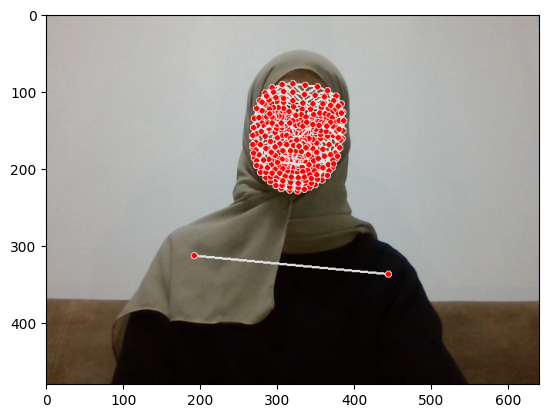

In [100]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [11]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Setup Folders for Collection

In [12]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('sign_language_dataset') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [13]:
signs = ['hello','thanks','iloveyou']

parent_folder = 'sign_language_dataset'

if not os.path.exists(parent_folder):
    os.mkdir(parent_folder)
    for sign in signs:
        sign_folder = os.path.join(parent_folder, sign)
        os.mkdir(sign_folder)
        for i in range(30):
            subfolder = os.path.join(sign_folder, str(i))
            os.mkdir(subfolder)


In [14]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('sign_language_dataset') 

# Actions that we try to detect
actions1 = np.array(['yes', 'no', 'help', 'goodbye'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30




# New signs to add
new_signs = ['yes', 'no', 'help' , 'goodbye']

# Folder for new signs
parent_folder = 'sign_language_dataset'

# Create folders for new signs
for sign in new_signs:
    sign_folder = os.path.join(parent_folder, sign)
    if not os.path.exists(sign_folder):  # Only create if it doesn't exist
        os.mkdir(sign_folder)
        for i in range(30):  # Create subfolders for sequences
            subfolder = os.path.join(sign_folder, str(i))
            os.mkdir(subfolder)

# Collect Keypoint Values for Training and Testing

In [16]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [73]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Define the new signs for which you want to extract keypoints
    new_signs = ['help' ,'goodbye','no','yes']

    # Loop through actions
    for action in actions:
        # Check if the action is in the new signs list
        if action not in new_signs:
            continue  # Skip the action if it's not one of the new signs

        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # Export keypoints only for the new signs
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()


In [15]:
cap.release()
cv2.destroyAllWindows()

# Preprocess Data and Create Labels and Features

In [16]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [17]:
label_map = {label:num for num, label in enumerate(actions)}

In [18]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [19]:
label_map1 = {label:num for num, label in enumerate(actions1)}
label_map1

{'yes': 0, 'no': 1, 'help': 2, 'goodbye': 3}

In [20]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [21]:
sequences1, labels1 = [], []
for action in actions1:  # actions1 is a list containing the new actions like ['no', 'yes', 'goodbye']
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences1.append(window)
        labels1.append(label_map1[action])


In [22]:
X = np.array(sequences)

In [23]:
y = to_categorical(labels).astype(int)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [25]:
X1 = np.array(sequences1)
y1 = to_categorical(labels1).astype(int)

In [26]:
# Split the data for actions
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.05)

# Build and Train LSTM Neural Network

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Input
from keras.callbacks import TensorBoard

In [28]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
#While training access tensorboard
#tensorboard --logdir=.

In [29]:
model = Sequential()
model.add(Input(shape=(30,1662)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [30]:
# Define the model for actions1
model_actions1 = Sequential()
model_actions1.add(Input(shape=(30, 1662)))  # Same input shape
model_actions1.add(LSTM(64, return_sequences=True, activation='relu'))
model_actions1.add(LSTM(128, return_sequences=True, activation='relu'))
model_actions1.add(LSTM(64, return_sequences=False, activation='relu'))
model_actions1.add(Dense(64, activation='relu'))
model_actions1.add(Dense(32, activation='relu'))
model_actions1.add(Dense(len(actions1), activation='softmax'))  # Using len(actions1) for output layer


In [31]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [51]:
model_actions1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [24]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - categorical_accuracy: 0.2994 - loss: 1.1811
Epoch 2/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.3992 - loss: 1.4772
Epoch 3/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.4617 - loss: 1.4083
Epoch 4/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.3209 - loss: 1.5395
Epoch 5/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.4423 - loss: 1.4191
Epoch 6/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.4110 - loss: 1.1144
Epoch 7/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.5538 - loss: 1.0880
Epoch 8/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.5381 - loss: 1.0297
Epoch 9/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.5225 - loss: 0.9836
Epoch 10/2000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.5832 - loss: 0.9162
Epoch 11/2000
3/3 ━━━━━━━━━━━

In [39]:
model_actions1.fit(X_train1, y_train1, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.5112 - loss: 1.4673
Epoch 2/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.5425 - loss: 1.6159
Epoch 3/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.6080 - loss: 2.6522
Epoch 4/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.4738 - loss: 2.1951
Epoch 5/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.6083 - loss: 1.6209
Epoch 6/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.5998 - loss: 2.1107
Epoch 7/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.4953 - loss: 3.4578
Epoch 8/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.5623 - loss: 2.2119
Epoch 9/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.6102 - loss: 1.2697
Epoch 10/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.4931 - loss: 1.4653
Epoch 11/2000
4/4 ━━━━━━━━━━━

KeyboardInterrupt: 

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,675 (2.28 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_actions1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,708 (2.28 MB)

 Trainable params: 596,708 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

# Make Predictions

In [50]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [73]:
res1=model_actions1.predict(X_test1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [70]:
actions[np.argmax(res[2])]

'hello'

In [78]:
actions1[np.argmax(res1[2])]

'no'

In [71]:
actions[np.argmax(y_test[2])]

'iloveyou'

In [79]:
actions1[np.argmax(y_test1[3])]

'help'

# Save Weights

In [88]:
model.save('./model.keras')
model.save_weights('./model_weights.weights.h5');

In [59]:
model_actions1.save('./model1.keras')
model_actions1.save_weights('./model1_weights.weights.h5');

In [ ]:
del model

In [52]:
import tensorflow as tf
model = tf.keras.models.load_model('model.keras')



In [53]:
model.load_weights('model_weights.weights.h5')

In [54]:
import tensorflow as tf 
model1=tf.keras.models.load_model('model1.keras')

In [55]:
model_actions1.load_weights('./model1_weights.weights.h5')

# Evaluation using Confusion Matrix

In [57]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [56]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


In [58]:
yhat1=model_actions1.predict(X_test1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


In [59]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [60]:
ytrue1 = np.argmax(y_test1, axis=1).tolist()
yhat11 = np.argmax(yhat1, axis=1).tolist()
multilabel_confusion_matrix(ytrue1,yhat11)

array([[[3, 0],
        [1, 2]],

       [[3, 1],
        [0, 2]],

       [[4, 1],
        [1, 0]]], dtype=int64)

In [61]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [62]:
accuracy_score(ytrue, yhat)


1.0

In [63]:
accuracy_score(ytrue1,yhat11)

0.6666666666666666

# Realtime Test

In [78]:
from scipy import stats

In [80]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [81]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [82]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

# Define actions and colors for the second model
actions1 = ["yes", "no", "help", "goodbye"]
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0)]

cap = cv2.VideoCapture(0)
# Set MediaPipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            # Use the second model for prediction
            res1 = model_actions1.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions1[np.argmax(res1)])  # Print the detected action from model_actions1
            predictions.append(np.argmax(res1))
            
        # 3. Visualization logic
            if np.unique(predictions[-10:])[0] == np.argmax(res1): 
                if res1[np.argmax(res1)] > threshold: 
                    if len(sentence) > 0: 
                        if actions1[np.argmax(res1)] != sentence[-1]:
                            sentence.append(actions1[np.argmax(res1)])
                    else:
                        sentence.append(actions1[np.argmax(res1)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Visualize probabilities
            image = prob_viz(res1, actions1, image, colors)
            
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [52]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

signs = ['hello', 'thanks', 'iloveyou']
actions = np.array(['hello', 'thanks', 'iloveyou'])


mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR-CONVERSION BGR-to-RGB
    image.flags.writeable = False                  # Convert image to not-writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Convert image to writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR-COVERSION RGB-to-BGR
    return image, results

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])
    
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

model = tf.keras.models.load_model('model.keras')
model.load_weights('model_weights.weights.h5')
model.summary()

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        #print(sentence)
        #word = sentence[-1:]
        #convert_to_audio(word[0]) if (len(word) != 0) else print("word not detected yet")
        #convert_to_audio(word[0])
        
        # Show to screen
        cv2.imshow('Realtime LSTM Sign Language Detection', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,193,352 (4.55 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 596,677 (2.28 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1